In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

Bi-LSTM(Attention)中的注意力机制的输入： lstm的隐藏层和输出

本代码是进行句子的情感分类

In [13]:
embedding_dim = 2
n_hidden = 5
num_classes = 2
sentences = ["i love you", "he loves me", "she likes baseball", "i hate you", "sorry for that", "this is awful"]
labels = [1, 1, 1, 0, 0, 0]

word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_dict = {w:i for i,w in enumerate(word_list)}
vocab_size = len(word_dict)

inputs = torch.LongTensor([np.asarray([word_dict[n] for n in sen.split()]) for sen in sentences])
targets = torch.LongTensor([out for out in labels])

In [11]:
class BiLSTM_Attention(nn.Module):
    def __init__(self):
        super(BiLSTM_Attention, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, n_hidden,bidirectional=True)
        self.out = nn.Linear(n_hidden*2, num_classes)
    
    def attention_net(self, lstm_output, final_state):
        # lstm_output: (6,3,10) (batch_size, n_step, n_hidden*2)
        # final_state: (2,6,5) (num_layer*num_directions, batch_size, n_hidden)
        hidden = final_state.view(-1, n_hidden*2, 1) # (6, 10, 1)
        
        attn_weights = torch.bmm(lstm_output, hidden).squeeze(2)   # (6,3,10) * (6,10,1) -> (6,3,1) -> (6,3)
        soft_attn_weights = F.softmax(attn_weights, 1)
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        # (6,10,3) * (6,3,1) -> (6,10,1) -> (6,10) context
        return context, soft_attn_weights.data.numpy()
    
    def forward(self, X):
        input = self.embedding(X)  # X (6,3) -> input (6,3,2)
        input = input.permute(1, 0, 2) # (6,3,2) -> (3, 6, 2) 即 (sequence_length, batch_size, embedding_size)
        hidden_state = torch.zeros(1*2, len(X), n_hidden) # (2, 6, 5) 
        cell_state = torch.zeros(1*2, len(X), n_hidden)
        output, (final_hidden_state, final_cell_state) = self.lstm(input,(hidden_state, cell_state))
        # output (3, 6, 10) 
        # final_hidden_state (2, 6, 5)
        output = output.permute(1, 0, 2) # output (6, 3, 10)
        attn_output, attention = self.attention_net(output, final_hidden_state)
        # attn_output (batchsize, n_hidden*2)
        return self.out(attn_output), attention  # model: (batch_size, num_classes) attention: (batch_size, n_step)
    # n_step 和 sequence_length是同一个

In [12]:
model = BiLSTM_Attention()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
for epoch in range(5000):
    optimizer.zero_grad()
    output, attention = model(inputs)
    loss = criterion(output, targets)
    if (epoch+1) % 1000 == 0:
        print(epoch+1, loss)
    loss.backward()
    optimizer.step()

1000 tensor(0.0037, grad_fn=<NllLossBackward>)
2000 tensor(0.0008, grad_fn=<NllLossBackward>)
3000 tensor(0.0003, grad_fn=<NllLossBackward>)
4000 tensor(0.0002, grad_fn=<NllLossBackward>)
5000 tensor(8.3959e-05, grad_fn=<NllLossBackward>)


In [16]:
test_text = 'sorry hate you'
tests = [np.asarray([word_dict[n] for n in test_text.split()])]
test_batch = torch.LongTensor(tests)
test_batch

tensor([[1, 8, 4]])

In [17]:
predict, _ = model(test_batch)

In [18]:
predict

tensor([[ 4.8092, -4.8284]], grad_fn=<AddmmBackward>)

In [19]:
predict = predict.data.max(1, keepdim=True)[1]

In [20]:
predict

tensor([[0]])

In [21]:
if predict[0][0] == 0:
    print(test_text, 'is Bad Mean..')
else:
    print(test_text, 'is Good Mean!')

sorry hate you is Bad Mean..


In [23]:
attention

array([[0.02443154, 0.9443099 , 0.03125861],
       [0.25899917, 0.23904687, 0.50195396],
       [0.00733469, 0.03585967, 0.95680565],
       [0.1830725 , 0.23434542, 0.5825821 ],
       [0.6695529 , 0.3142739 , 0.01617326],
       [0.8733531 , 0.11534436, 0.01130259]], dtype=float32)

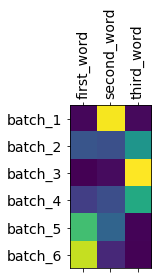

In [22]:
fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(1, 1, 1)
ax.matshow(attention, cmap='viridis')
ax.set_xticklabels(['']+['first_word', 'second_word', 'third_word'], fontdict={'fontsize': 14}, rotation=90)
ax.set_yticklabels(['']+['batch_1', 'batch_2', 'batch_3', 'batch_4', 'batch_5', 'batch_6'], fontdict={'fontsize': 14})
plt.show()